# Modelos lineales, un caso de estudio con la data de NHANES

Este notebook introduce dos metodos de modelado estadistico: regresion lineal y regresion logistica. El enfoque es en ajustar estos dos tipos de modelos a la data usando las librerias de Python. Como en los otros casos de estudio, vamos a analizar la data de [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) para ilustrar el uso de estos dos modelos de regresion a la hora de abordar preguntas de investigacion con data real.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [3]:
# Read the 2015-2016 wave of NHANES data
da = pd.read_csv("../data/nhanes_2015_2016.csv")

# Drop unused columns, and drop rows with any missing values.
cols = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "BMXBMI", "SMQ020"]
da = da[cols].dropna()

## Regresion lineal

Inicialmente nos vamos a enfocar en modelos de regresion donde la systolic [blood pressure](https://en.wikipedia.org/wiki/Blood_pressure) (SBP) es la variable dependiente. Es decir, vamos a predecir SBP de otras variables. SBP tiende a ser un buen indicador de salud cardiovascular. Tiende a incrementar con la edad, es mas alta para personas con sobre peso (un BMI mayor) y tambien difiere entre grupos demograficos, como por ejemple entre genero y grupos etnicos.

Ya que SBP es una variable cuantitativa, vamos a modelarla usando una regresion lineal. La regresion lineal es la forma de regresion estadistica mas utilizada. Aunque la regresion lineal no es el unico tipo de modelo de regresion que se puede usar es un excelente punto de partida para modelar variables cuantitativas.


### Interpretando los parametros de regresion en un modelo basico

Empezamos con una simple regresion lineal con un solo covariable, edad, prediciendo SBP. En la data de NHANES la variable [BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1) contiene la primera medida registrada de SBP para un sujeto y [RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR) es la edad del sujeto en anios. El modelo ajustado en la siguiente celda expresa el SBP esperado como una funcion lineal de edad:

In [12]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     1333.
Date:                Thu, 07 May 2020   Prob (F-statistic):          2.09e-259
Time:                        21:06:32   Log-Likelihood:                -21530.
No. Observations:                5102   AIC:                         4.306e+04
Df Residuals:                    5100   BIC:                         4.308e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.0935      0.685    149.120      0.000     100.751     103.436
RIDAGEYR       0.4759      0.013     36.504      0.000       0.450       0.501
==============================================================================
Omnibus:                      690.261   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1505.999
Skew:                           0.810   Prob(JB):                         0.00
Kurtosis:                       5.112   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mucho del output de arriba no es relevante para nosotros, enfoquense en la seccion en el centro del output donde el encabezado empieza con __coef__. Esta seccion contiene los valores estimados de los parametros de regresion del modelo, su error estandar y otros valores que se usan para cuantificar la incertidumbre en los estimados de los parametros de regresion.

Este modelo ajustado implica que cuando comparamos dos personas cuya edad difiere por un anio, la persona mayor va a tener, en promedio, 0.48 unidades de SBP mas alto que la persona mas joven. Esta diferencia es estadisticamente significativa, basado en el p-value bajo la columna con el nombre __`P>|t|`__. Esto significa que hay evidencia fuerte que hay una asociacion real entre SBP y edad en esta poblacion.

El SBP se mide en unidades de *milimetros de mercurio* expresado *mm/Hg**. Para poder entender mejor el significado del estimado del parametro de regresion 0.48, podemos ver la desviacion estandar de SBP:

In [8]:
da.BPXSY1.std()

18.486559500782416

La desviacion estandar de alrededor de 18.5 es grande comparada con la pendiente de regresion de 0.48. Sin embargo, la pendiente de regresion corresponde al cambio promedio en sBP para un solo anio de edad y este efecto se acumula con la edad. Comparando una persona de 48 anios con una de 60 anios, hay 20 anios de diferencia en edad, lo cual se traduce a `20 * 0.48 = 9.6` unidades de diferencia en edad, en SBP promedio entre estas dos personas. La diferencia esta cerca de la mitad de una desviacion estandar y generalmente se consideraria un cambio importante y significativo.

### R-cuadrado y correlacion

En el caso de regresion con una sola variable independiente, hay una correspondencia muy cercana entre el analisis de regresion el analisis de correlacion de Pearson. La estadistica resumida principal para evaluar la fuerza de una relacion predecida en un modelo de regresion es el *R-cuadrado*, que en nuestro caso fue de 0.207 en el modelo de regresion arriba. Esto significa que 21% de la variabilidad en SBP es explicada por la edad. Noten que este valor es exactamente igual al coeficiente de correlacion de Pearson cuadrado demostrado abajo entre SBP y edad.

In [9]:
cc = da[["BPXSY1", "RIDAGEYR"]].corr()
print(cc.BPXSY1.RIDAGEYR**2)

0.20715459625188243


Hay una segunda forma de interpretar el R-cuadrado, que hace uso de los *valores ajustados* de la regresion. Los valores ajustados son predicciones del SBP para cada persona en la data, basado en los valores de sus covariables. En este caso, el unico covariable es la edad, por lo que estamos prediciendo el SBP de cada sujeto en NHANES en funcion de la edad. Si caclulamos el coeficiente de correlacion de Pearson entre los valores ajustados de la regresion y los valores reales de SBP y luego cuadramos este coeficiente de correlacion, podemos ver que tambien obtenemos el R-cuadrado de la regresion:

In [10]:
cc = np.corrcoef(da.BPXSY1, result.fittedvalues)
print(cc[0, 1]**2)

0.20715459625186952


Por tanto, podemos ver que en un modelo lineal ajustado con una sola covariable, el R-cuadrado de la regresion es igual al coeficiente de correlacion de Pearson cuadrado entre la covariable y la variable dependiente, y tambien es igual al coeficiente de correlacion de pearson cuadrado entre los valores ajustados y la variable dependiente.

### Agregando una segunda variable

Arriba consideramos un analisis de un modelo de regresion lineal simple con una sola covariable (edad) prediciendo el SBP. El poder real de un analisis de regresion surge cuando tenemos mas de una covariable prediciendo el outcome (DV). Como mencionamos arriba se espera que el SBP este relacionado al genero al igual que a la edad, asi que vamos a agregar genero al modelo. La variable NHANES para genero se llama [RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)

Primero cambiamos los valores de la variable de genero.

In [11]:
# Create a labeled version of the gender variable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

Ahora estamos listos para ajustar el modelo:

In [12]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     697.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.87e-268
Time:                        05:14:37   Log-Likelihood:                -21505.
No. Observations:                5102   AIC:                         4.302e+04
Df Residuals:                    5099   BIC:                         4.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.6305      0.712    141.257      0.000      99.234     102.027
RIAGENDRx[T.Male]     3.2322      0.459      7.040      0.000       2.332       4.132
RIDAGEYR              0.4739      0.013     36.518      0.000       0.448       0.499
==============================================================================
Omnibus:                      706.732   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1582.730
Skew:                           0.818   Prob(JB):                         0.00
Kurtosis:                       5.184   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El syntax `RIDAGEYR + RIAGENDRx` en la celda de arriba no quiere decir que estas dos variables literalmente se suman. En vez, quiere decir que estamos incluyendo ambas variables en el modelo como predictoras de SBP.

El modelo ajustado arriba usa ambos genero y edad para explicar la variacion en SBP. Encuentra que dos personas con el mismo genero cuya edad difiere por un anio tienden a tener valores de SBP que difieren por 0.47 unidades, que es casi el mismo parametro que encontramos en el modelo anterior basado solamente en la edad. Este modelo nos demuestra que al comparar un hombre y una mujer de la misma edad, el hombre va a tener en promedio 3.23 unidades de SBP mas alto.

Es muy importante enfatizar que el coeficiente de edad de 0.47 solamente hace sentido cuando comparamos dos personas del mismo genero y el coeficiente de genero de 3.23 solo hace sentido cuando comparamos dos personas de la misma edad. Ademas, estos efectos son aditivos, lo cual significa que si comparamos un hombre de 50 anios contra una mujer de 40 anios, el SBP del hombre va a ser en promedio `3.23 + 10*0.47 = 7.93` unidades mas alto, donde el primer termino en la suma es atribuible al genero y el segundo termino es atribuible a la edad.

Notamos arriba que el coeficiente de regresion para edad no cambio mucho cuando agregamos genero al modelo. Es importante notar que en general, el coeficiente estimado de una variable en un modelo de regresion va a cambiar cuando se agreguen mas variables o se eliminen variables. La unica circumstancia donde el parametro de regresion no cambia cuando se agregan o eliminan variables es cuando esas variables no estan correlacionadas con las variables que siguen en el modelo.

Abajo confirmamos que genero y edad tienen muy poca correlacion en este dataset (una correlacion de -0.02 es insignificante). Por tanto, se espera que cuando agregamos genero al modelo, el coeficiente de edad no cambie.


In [13]:
# We need to use the original, numerical version of the gender
# variable to calculate the correlation coefficient.
da[["RIDAGEYR", "RIAGENDR"]].corr()

,RIDAGEYR,RIAGENDR
RIDAGEYR,1.000000,-0.021398
RIAGENDR,-0.021398,1.000000


### Variables categoricas y niveles de referencia

En el modelo ajustado arriba, genero es una variable categorica, y solo el coeficiente para hombres esta incluido en el output de la regresion (i.e. no hay coeficiente para mujeres en la taba arriba). Cuando una variable categorica es usada como una covariable en un modelo de regresion, un nivel de la variable se elimina y automaticamente se le otorga un coeficiente de cero. Este nivel se llama *nivel de referencia* de la covariable. Aqui, el nivel de mujer de la variable de genero es el nivel de referencia. Esto no quiere decir que ser mujer no tiene impacto en la presion arterial. Simplemente significa que hemos escrito el modelo de tal manera que el SBP de mujeres es el default y el coeficiente para hoombres (3.23) mueve el SBP por ese monto solamente para hombres.

Alternativamente podemos setiar 'male' para ser nuestro nivel de referencia, en cuyo caso los hombres serian el default y el coeficiente de mujer seria algo cerca a -3.23 (lo que significa que el SBP de las mujeres es 3.23 unidades mas bajo que el de los hombres).

Cuando usamos variables categoricas como predictores en un modelo de regresion, estos se codifican como variables "dummy" (tambien conocidas como variables indicadores). Una variable dummy para un solo nivel, digamos `a`, de una variable `x` es una variable que es igual a `1` cuando `x=a` y es igual a `0` cuando `x` no es igual a `a`. Estas variables dummy son incluidas en el modelo de regresion para representar la variable de la que fueron creadas.

Statsmodels, como muchos softwares, automaticamente va a recodificar una variable categoria en variables dummy y va a seleccionar un nivel de referencia (es posible cambiar que variable de referencia usa, pero no lo vamos a ver). Cuando interpretamos el resultado de una regresion, el nivel que es eliminado debe ser visto como teniendo un coeficiente de 0, con un erro estandar de 0. Es importante notar que la seleccion de un nivel de referencia es arbitraria y no implica una suposicion o una restriccion sobre el modelo, o sobre la poblacion.


### Un modelo con tres variables

Ahora vamos a agregar una tercera variable, BMI, al modelo prediciendo SBP.
[BMI](https://en.wikipedia.org/wiki/Body_mass_index) es una medida utilizada para evaluar si una persona tiene un peso sano dada su altura.
[BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)
es el nombre de la variable en NHANES.

In [15]:
model = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR + BMXBMI + RIAGENDRx", data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     502.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.54e-286
Time:                        05:14:41   Log-Likelihood:                -21461.
No. Observations:                5102   AIC:                         4.293e+04
Df Residuals:                    5098   BIC:                         4.296e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            91.5840      1.198     76.456      0.000      89.236      93.932
RIAGENDRx[T.Male]     3.5783      0.457      7.833      0.000       2.683       4.474
RIDAGEYR              0.4709      0.013     36.582      0.000       0.446       0.496
BMXBMI                0.3060      0.033      9.351      0.000       0.242       0.370
==============================================================================
Omnibus:                      752.325   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1776.087
Skew:                           0.847   Prob(JB):                         0.00
Kurtosis:                       5.343   Cond. No.                         316.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Como esperabamos, el BMI tiene una relacion positiva con SBP. Dados dos sujetos con el mismo genero y edad, y cuyo BMI difiere por 1 unidad, la persona con un BMI mas alto va a tener, en promedio, 0.31 unidades mas altas de SBP. Tambien noten que despues de agregar BMI al modelo, el coeficiente para genero incremento un poco. Esto se debe al hecho que las tres covariables del modelo: edad, genero y BMI estan correlacionadas, como pueden ver a continuacion:

In [16]:
da[["RIDAGEYR", "RIAGENDR", "BMXBMI"]].corr()

,RIDAGEYR,RIAGENDR,BMXBMI
RIDAGEYR,1.000000,-0.021398,0.023089
RIAGENDR,-0.021398,1.000000,0.080463
BMXBMI,0.023089,0.080463,1.000000


Aunque las correlaciones entre estas tres variables no son fuertes, es suficiente para inducir diferencias substanciales en los coeficientes de regresion (e.i. el coeficiente de genero cambio de 3.23 a 3.58). En este ejemplo, el efecto de genero se volvio mas grande luego de controlar por el BMI - podemos tomar esto como decir que el BMI esta "confundiendo" o "escondiendo" parte de la asociacion entre genero y SBP (piensen en el ejemplo de consumo de chocolate con cantidad de premios nobel). En otros contextos, incluir covariables adicionales puede reducir la asociacion entre una covariable y el outcome.


### Visualizacion de los modelos ajustados

En esta seccion, vamos a demostrar un par de tecnicas para graficar que pueden ser utilizadas para entender mejor el modelo de regresion que ha sido ajustado a la data.

Empezamos con graficas que nos permiten visualizar la funcion de regresion ajustada, es decir, el SBP promedio expresado como una funcion de las covariables. Estos plots ayudan a demostrar el rol estimado de una variable cuando las otras variables se mantienen fijas. Vamos a graficar *bandas de confianza simultaneas* de 95% alrededor de estas lineas ajustadas. Aunque la curva de la media estimada nunca es exacta basada en una muestra finita de data, podemos tener 95% de confianza que la curva media real caera en algun lugar entre la region sombreada de las graficas de abajo.

Este tipo de plot requiere que fijemos los valores de todas las variables aparte de la variable dependiente (SBP aqui), y una variable independiente que llamamos la *variable foco* (en este caso edad). Abajo fijamos el genero como "female" y el BMI como 25. Por tanto, las graficas abajo demuestran la relacion entre SBP y edad para mujeres con BMI igual a 25.

/opt/conda/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'smq' in data frame but not in summaries or values.
  ValueWarning)


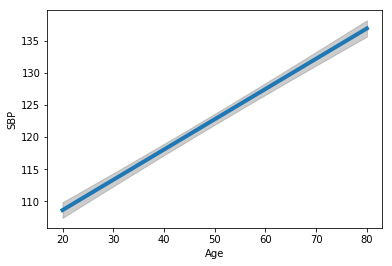

In [17]:
from statsmodels.sandbox.predict_functional import predict_functional

# Fix certain variables at reference values.  Not all of these
# variables are used here, but we provide them with a value anyway
# to prevent a warning message from appearing.
values = {"RIAGENDRx": "Female", "RIAGENDR": 1, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1}

# The returned values are the predicted values (pr), the confidence bands (cb),
# and the function values (fv).
pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
_ = ax.set_ylabel("SBP")

Hacemos lo mismo para BMI abajo. Fijamos genero a "female" y edad a 50. Estamos viendo la relacion entre SBP y edad para mujeres de 50 anios.

/opt/conda/lib/python3.6/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'smq' in data frame but not in summaries or values.
  ValueWarning)


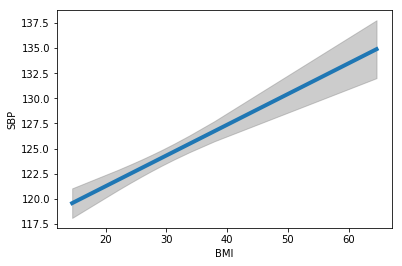

In [18]:
del values["BMXBMI"] # Delete this as it is now the focus variable
values["RIDAGEYR"] = 50
pr, cb, fv = predict_functional(result, "BMXBMI",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("BMI")
_ = ax.set_ylabel("SBP")

Las bandas de error para BMI es notablemente mas ancha que la banda de error para edad, indicando que hay menos certeza sobre la relacion entre BMI y SBP comparado con la relacion entre edad y SBP.

## Regresion logistica

Ahora vamos a ver modelos de regresion para variables dependientes *binarias*, es decir que el outcom puede tomar uno de dos valores. Para ilustrar esto, vamos a trabajar con la variable de [SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020), que pregunta si una persona a fumado al menos 100 cigarrillos en su vida (si este es el caso, decimos que la persona tiene un "historial de fumar"). Abajo creamos una version de esta variable en donde fumador y no fumador estan codificados como 1 y 0, respectivamente, y respuestas raras como *don't know* y *refused to answer* son codificadas como valores faltantes.

In [9]:
da.RIAGENDR.head()

0    1
1    1
2    1
3    2
4    2
Name: RIAGENDR, dtype: int64

In [10]:
pd.get_dummies(da.RIAGENDR).head()

,1,2
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1


In [23]:
da["smq"] = da.SMQ020.replace({2: 0, 7: np.nan, 9: np.nan})

### Odds y log odds

La regresion logistica provee un modelo para los *odds* de que un evento suceda. Recuerden que si un evento tiene una probabilidad `p`, entonces los odds de ese evento son `p/(1-p)`. Los odds son una transformacion matematica de la probabilidad a una escala diferente. Por ejemplo, si la probabilidad es de 1/2, los odds son de 1.

Para empezar, vamos a ver los odds de uso de alcohol para mujeres y hombres por separado.

In [25]:
c = pd.crosstab(da.RIAGENDRx, da.smq).apply(lambda x: x/x.sum(), axis=1)
c["odds"] = c.loc[:, 1] / c.loc[:, 0]
c

smq,0.0,1.0,odds
RIAGENDRx,,,
Female,0.680197,0.319803,0.470162
Male,0.467453,0.532547,1.139252


Vemos que la probabilidad de que una mujer haya fumado es substancialmente mas baja que la probabilidad de que un hombre haya fumado (30% vs 51%). Esto se ve reflejado en los odds para un mujer son mucho menores a 1 (alrededor de 0.47), mientras que los odds de que un hombre fume son de ~1.14.

Es comun trabajar con *odds ratios* cuando comparamos dos grupos. Esto simplemente son los odds para un grupo dividido por los odds para el otro grupo. El odd ratio para fumar, comparando hombres a mujeres, es alrededor de 2.4. En otras palabras, un hombre tiene alrededor de 2.4 veces mayores odds de fumar que una mujer (en una polbacion representada por esta data).

In [26]:
c.odds.Male / c.odds.Female

2.423105552613186

Es convencional trabajar con odds en la escala logaritmica. Para entender porque se hace esto, primero noten que el punto neutro para una probabilidad es 0.5, lo cual es equivalente a un ods de 1 y un log odds de 0. Poblaciones donde los hombres fuman mas que las mujeres van a tener odds entre 1 e infinito, con el valor exacto dependiendo en la magnitud de la relacion entre las tasas de fumar de hombres y mujeres. Poblaciones donde las mujeres fuman mas que los hombres van a tener odds entre 0 y 1.

Vemos que la escala de la estadistica de odds no es simetrica. Usualmente es arbitrario en que orden comparamos dos grupos -- podemo comparar hombres con mujeres o mujeres con hombres. Un odds de 2 (hombres tienen el doble de odds de fumar que las mujeres) es equivalente en fuerza a un odds de 1/2 (las mujeres tienen el doble de odds de fumar que los hombres). Tomar el log de los odds centra la escala en cero, y vuelve simetrica la interpretacion de la escala.

Para interpretar los log odds cuando comparamos dos grupos, es importante recordar lo siguiente:

* Una probabilidad de 1/2, un odds de 1 y un log odds de 0 son equivalentes.

* Un log odds positivo indica que el primer grupo que esta siendo comparado tiene mayores odds (y mayor probabilidad) que el segundo grupo.

* Un log odds negativo indica que el segundo grupo siendo comparado tiene mayores odds (y mayor probabilidad) que el primer grupo.

* La escala de la estadistica de log odds es simetrica en el sentido que un log odds de, e.i. 2, es equivalente en fuerza que un log odds de -2 (pero con los grupos cambiados en terminos de cual tiene la mayor probabilidad)

Si saben que el log odds cuando comparan dos grupos es un valor como por ejemplo 2 y quieren reportar los odds, simplemente exponencien el log odds para obtener el odds. e.i. `exp(2)` es alrededor de 7.4. Sin embargo, noten que no pueden recuperar las probabilidades individuales de un odds ratio.

`
Abajo mostramos los log odds para el estado de fumar de mujeres y hombres en la data. El hecho que los log odds para las mujeres es negativo refleja que substancialmente menos de 50% de las mujeres tienen un historial de fumar. Los log odds de los hombres estan mas cerca a 0, consistente con que alrededor de la mitad de los hombres tienen un historial de fumar`

In [27]:
c["logodds"] = np.log(c.odds)
c

smq,0.0,1.0,odds,logodds
RIAGENDRx,,,,
Female,0.680197,0.319803,0.470162,-0.754679
Male,0.467453,0.532547,1.139252,0.130371


### Un modelo de regresion logistica basico

Ahora que tenemos un entendimiento claro de estadisticas de log odds, vamos a ajustar un modelo de regresion. La variable dependiente (outcome) de este modelo inicial es el estado de fumar, y el unico covariable es genero. Por tanto, estamos viendo el genero como predictor del estado de fumar. Vamos a ajustar el modelo usando la funcion `GLM`, donde `GLM` significa *Generalized Linear Model*. La regresion logistica es un tipo de GLM, una clase que tambien incluy muchos metodos de regresion como una regresion Poisson, por ejemplo. Como la regresion lineal, la regresion logistica incluye un parametro de intercepto, pero no nos vamos a enfocar en el.

In [28]:
model = sm.GLM.from_formula("smq ~ RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5092
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3350.6
Date:                Mon, 27 Apr 2020   Deviance:                       6701.2
Time:                        05:17:13   Pearson chi2:                 5.09e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7547      0.042    -18.071      0.000      -0.837      -0.673
RIAGENDRx[T.Male]     0.8851      0.058     15.227      0.000       0.771       0.999
=====================================================================================
"""

Para ver la conexion entre regresion logistica y la estadistica log odds, noten que el coeficiente para el genero hombre de la regresion logistica es exactamente igual a la diferencia entre los log odds para hommbres y mujeres:

In [24]:
c.logodds.Male - c.logodds.Female

0.88505000366442177

Esta relacion siempre se va a mantener cuando realicen una regresion logistica con una covariable binaria.

En general, un modelo de regresion logistico va a tener multiples covariables que pueden no ser binarios, pero igual siempre hay una conexion importante entre una regresion logistica y odds ratios. En este contexto mas general, vamos a usar un tipo de odds ratios mas general, que vamos a explorar mas a continuacion.


### Agregando covariables adicionales

Como con la regresion lineal, podemos incluir multiples covariables en una regresion logistica. Abajo ajustamos una regresion logistica para estado de fumar usando edad (RIDAGEYR) y genero como covariables.

In [29]:
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5091
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3296.6
Date:                Mon, 27 Apr 2020   Deviance:                       6593.2
Time:                        05:18:39   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6166      0.095    -16.985      0.000      -1.803      -1.430
RIAGENDRx[T.Male]     0.8920      0.059     15.170      0.000       0.777       1.007
RIDAGEYR              0.0172      0.002     10.289      0.000       0.014       0.021
=====================================================================================
"""

Agregar edad al modelo nos lleva a un pequenio cambio en el parametro de genero (cambio de 0.885 a 0.892). En general, los coeficientes de regresion pueden cambiar mucho cuando agreguen o eliminen otras variables del modelo. En este caso el cambio fue minimo. Este modelo ajustado sugiere que personas mayores tienen mayor probabilidad de tener un historial de fumar que personas menores. Los log odds para fumar incrementan por 0.017 por cada anio de edad. Este efecto es aditivo, entonces cuando comparamos dos personas cuyas edades difieren por 20 anios, los log odds de que la persona mayor fume van a ser alrededor de 0.34 unidades mas altos que los log odds de que la persona menor fume y los odds de que la persona mayor fume van a ser alrededor de `exp(0.34) = 1.4` veces mas altos que los odds de que una persona menor fume.

Como con la regresion lineal, el rol de la edad y genero en la regresion logistica puede ser vistos como aditivos, pero aqui la aditividad esta en la escala de log odds, no de odds o de probabilidades. Si comparamos una mujer de 30 anios con un hombre de 50 anios, los log odds de que el hombre sea fumador son `0.89 + 0.34 = 1.23` unidades mayores que los log odds de que la mujer sea fumadora. El valor de 0.89 en esta ecuacion es el cambio que se puede atribuir al genero, y el valor de 0.34 es el cambio atribuible a la edad. De nuevo, podemos exponenciar para convertir estos efectos de la escala de log odds a la escala de odds. Como `exp(0.89 + 0.34) = exp(0.89)*exp(0.34) = 2.44*1.41` podemos decir que ser hombre esta asociado a un incremento de 2.44 veces en los odds de fumar y 20 anios de fumar esta asociado a un incremento de 1.41 veces mayor en los odds de fumar. Estos dos efectos se multiplican cuando discutimos los odds, asi que un hombre de 50 anios tiene `exp(1.23) = 3.42` mayores odds de fumar que una mujer de 30 anios.


El coeficiente de ~0.89 para hombres impacta los log odds condicionales en el sentido que cuando comparamos un hombre con una mujer a una edad fija, el hombre va a tener 0.89 unidades de log odds mas altas de fumar que la mujer. Esta relacion se mantiene entre cualquier edad. En este sentido, es un *coeficiente condicional* porque solamente es interpretable cuando fijamos las otras variables en el modelo. Similarmente, el coeficiente de ~0.02 para edad se mantiene dentro de un genero. Comparando dos mujeres cuya edad es diferente por un anio, la mujer mas grande tiene 0.02 unidades de log odds mas altas de fumar que la mujer joven. Este mismo contraste se mantiene para hombres.


### Un modelo de regresion logistica con tres predictores

A continuacion ajustamos una regresion logistica, de nuevo para fumar, incluyendo el nivel educativo como predictor, en NHANES esta variable se llama [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2), y la vamos a recodificar para que el significado de sus niveles sea mas claro. Vamos a llamar la variable recodificada: `DMDEDUC2x`.

In [30]:
# Create a labeled version of the educational attainment variable
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "lt9", 2: "x9_11", 3: "HS", 4: "SomeCollege",
                                       5: "College", 7: np.nan, 9: np.nan})

model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx + DMDEDUC2x", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5093
Model:                            GLM   Df Residuals:                     5086
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3201.2
Date:                Mon, 27 Apr 2020   Deviance:                       6402.4
Time:                        05:19:28   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3060      0.114    -20.174      0.000      -2.530      -2.082
RIAGENDRx[T.Male]            0.9096      0.060     15.118      0.000       0.792       1.028
DMDEDUC2x[T.HS]              0.9434      0.090     10.521      0.000       0.768       1.119
DMDEDUC2x[T.SomeCollege]     0.8322      0.084      9.865      0.000       0.667       0.998
DMDEDUC2x[T.lt9]             0.2662      0.109      2.438      0.015       0.052       0.480
DMDEDUC2x[T.x9_11]           1.0986      0.107     10.296      0.000       0.889       1.308
RIDAGEYR                     0.0183      0.002     10.582      0.000       0.015       0.022
============================================================================================
"""

Podemos ver que el nivel "Female" de la variable genero, y el nivel "College" de la variable de educacion son los niveles de referencia ya que no salen en el output de arriba. Hemos discutido las variables de genero y edad arriba, pero la variable de nivel educacional es nueva. Todos los coeficientes que no son de referencia para nivel educacional son positivos, mientras que el coeficiente de `College`, como coeficiente de referencia, es exactamente cero. Por tanto, podemos ver que las personas con un titulo universitaro tienen la tasa mas baja de fumar, seguido por personas con menos de 9 anios de educaciones, etc.

Como notamos arriba, es importante recordar que un coeficiente en una regresion logistica es "condicional" con que las otras variables se mantengan fijas.


### Visualizacion de los modelos ajustados

La visualizacion de los modelos de regresion logistica ajustados son mas complejos que visualizar una regresion lineal, pero vale la pena intentar. Podemos empezar graficando la proporcion de la poblacion ajustada que fuma, para varias subpoblaciones definidas por el modelo de regresion. Nos vamos a enfocar en como la tasa de fumar varia con edad, entonces restringimos la poblacion a mujeres graduadas de la universidad.

El siguiente plot demuestra la probabilidad log odds (o logit) ajustada para el outcome de fumar como una funcion de edad. La banda gris es una banda de confianza de 95% simultanea, como discutimos arriba en el caso de la regresion lineal.

Text(0,0.5,'Smoking')

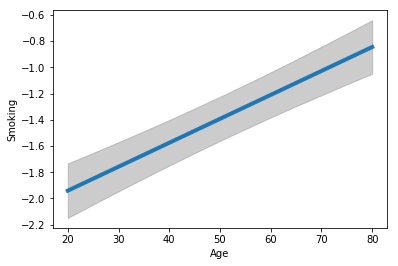

In [31]:
values = {"RIAGENDRx": "Female", "RIAGENDR": 1, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1,
          "DMDEDUC2x": "College", "BPXSY1": 120}

pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
ax.set_ylabel("Smoking")

Podemos mostrar el mismo plot en terminos de probabilidades en vez de log odds. La probabilidad puede ser obtenida de los log odds usando la relacion `p = 1 / (1 + exp(-o))` donde `o` son los log odds. Noten que mientras la edad y los log odds estan linealmente relacionados, edad tiene una relacion curvada con probabilidad. Esto es necesario ya que las probabilidades se mantienen entre 0 y 1, una relacion lineal eventualmente se saldria de este intervalo.

Text(0,0.5,'Smoking')

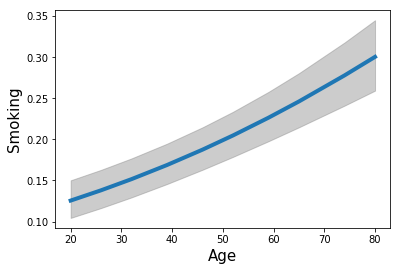

In [28]:
pr1 = 1 / (1 + np.exp(-pr))
cb1 = 1 / (1 + np.exp(-cb))
ax = sns.lineplot(fv, pr1, lw=4)
ax.fill_between(fv, cb1[:, 0], cb1[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Smoking", size=15)